# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
import warnings

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter = ";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter = ";")

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print ("The general demographics data has {} rows and {} columns".format(*azdias.shape))
display(azdias.head())

The general demographics data has 891221 rows and 85 columns


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("The feature summary data has {} rows and {} columns".format(*feat_info.shape))
display(feat_info.head())

The feature summary data has 85 rows and 4 columns


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
def ConvertMissingValueCodesToNaNs(azdias, tab, feat_info):
    ct = 0
    for i,j in enumerate(azdias.iteritems()):
        tab = tab
        if feat_info['missing_or_unknown'][i][1:-1].split(',') != ['']:
            for item in (feat_info['missing_or_unknown'][i][1:-1].split(',')):
                if item in ['X','XX']: 
                    tab.append(item)
                    ct = ct + 1
                else: 
                    tab.append(int(item))
            azdias[j[0]] = azdias[j[0]].replace(tab, np.nan)
    return tab

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
tab = ConvertMissingValueCodesToNaNs(azdias, [], feat_info)
        
# print the data
display(azdias.head())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,NaN,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,NaN,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
def assessment1(azdias, figsize, kind, x, y, title):
    assessment = azdias.isnull().sum()/1000000
    assessment.plot(kind=kind, figsize=figsize)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)

In [9]:
def assessment2(azdias, figsize, bins, x, y, title):
    assessment = azdias.isnull().sum()/1000000
    assessment.hist(figsize=figsize, bins=bins)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)

In [10]:
def patterns(azdias, figsize, cbar):
    plt.figure(figsize=figsize)
    sns.heatmap(azdias.isnull(),cbar=cbar)

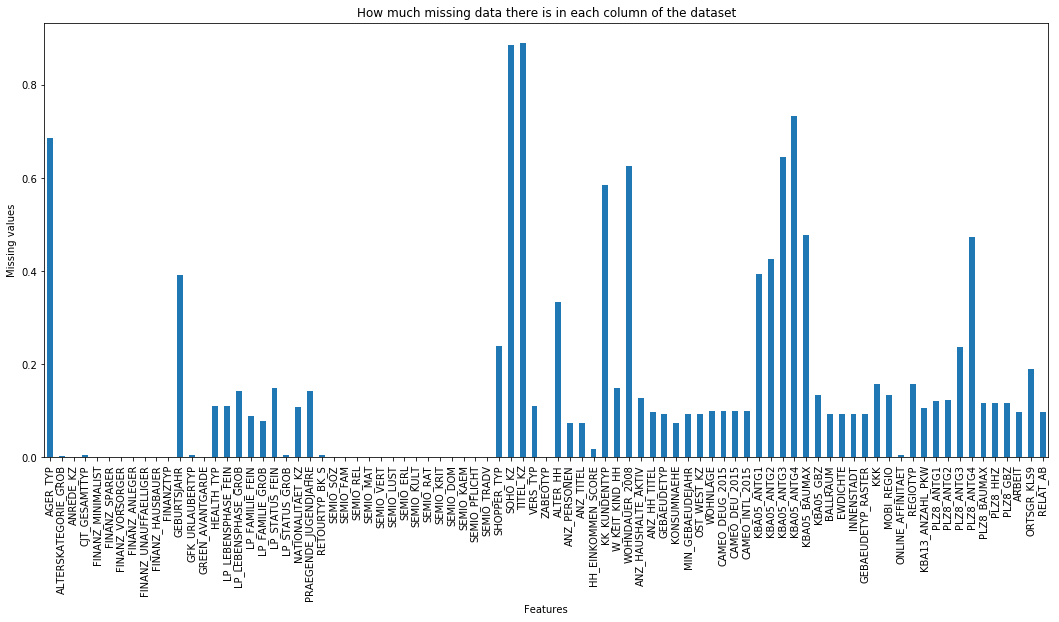

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
figsize = (18,8)
kind = 'bar'
x = 'Features'
y = 'Missing values'
title = 'How much missing data there is in each column of the dataset'
assessment1(azdias, figsize, kind, x, y, title)


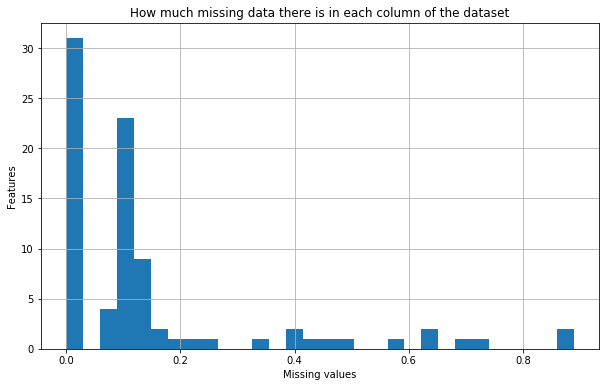

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
figsize = (10,6)
bins = 30
x = 'Missing values'
y = 'Features'
title = 'How much missing data there is in each column of the dataset'
assessment2(azdias, figsize, bins, x, y, title)


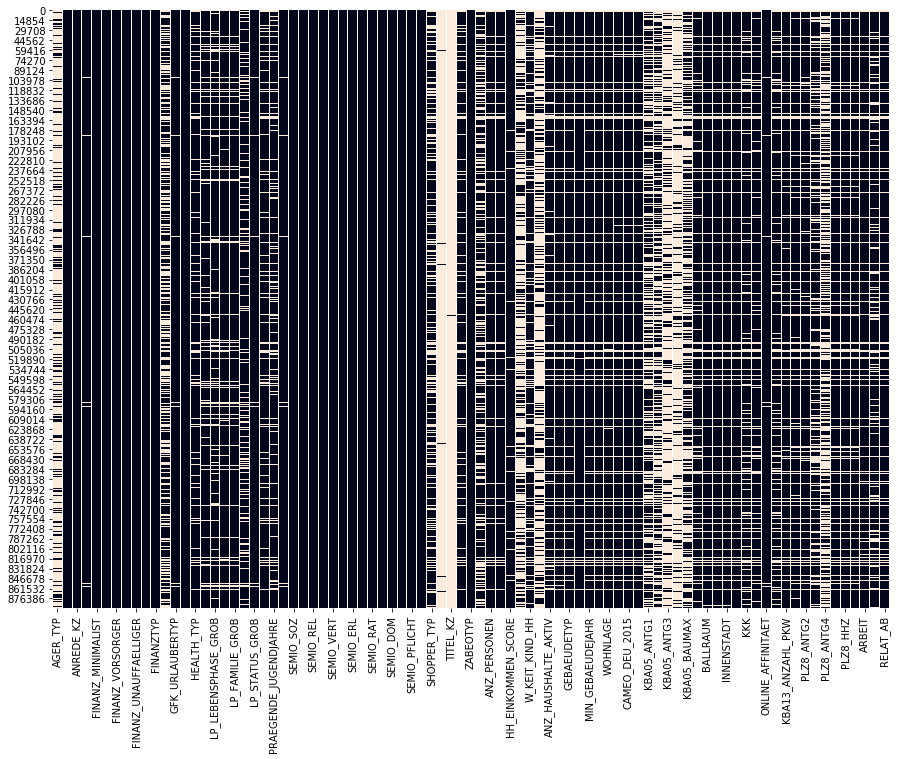

In [13]:
# Investigate patterns in the amount of missing data in each column.
figsize=(15,11)
cbar=False
patterns(azdias, figsize, cbar)

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

rem = azdias.isnull().sum()/1000000
missing = rem[rem > 0.20].index
pd.DataFrame(missing, columns=("Outlier columns",))

,Outlier columns
0,AGER_TYP
1,GEBURTSJAHR
2,SHOPPER_TYP
3,SOHO_KZ
4,TITEL_KZ
5,ALTER_HH
6,KK_KUNDENTYP
7,WOHNDAUER_2008
8,KBA05_ANTG1
9,KBA05_ANTG2


In [15]:
def remove_outlier(azdias, tab, feat_info, missing):
    # Remove the outlier columns from azdias
    azdias.drop(missing, axis=1, inplace=True)

    # Remove the outlier rows from features info
    for i,j in enumerate(feat_info['attribute']):
        if j in missing:
            tab.append(i)
    feat_info.drop(tab, inplace=True) 

In [16]:
# Remove the outliers
remove_outlier(azdias, [], feat_info, missing)

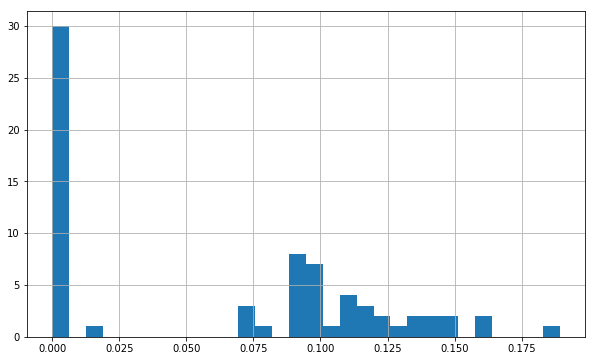

In [17]:
# Print the graph after removing the outliers
assessment2(azdias, (10,6), 30, '', '', '')

#### Discussion 1.1.2: Assess Missing Data in Each Column

Yes, there are patterns in the missing values. Note that, a similar pattern in the PLZ8 columns around 13%, in the AMZ_TITEL, AMZ_PERSONEN, WOHNDAUER_2008 columns around 10%, and in the NATIONALITAET_KZ, SHOPPER_TYPE columns around 11%. Furthermore, a similar missing in the KBAOS columns around 15%. Moreover, 
the LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB columns look similar in the bar plot, however, they have some differences in their pattern. 

I took features with missing values **greater than 20%** as outliers here, such that observed in the table above. Also, These columns were dropped from the dataset. Furthermore, some columns were recorded with no missing values (all the FINANZ, and all the SEMIO).



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

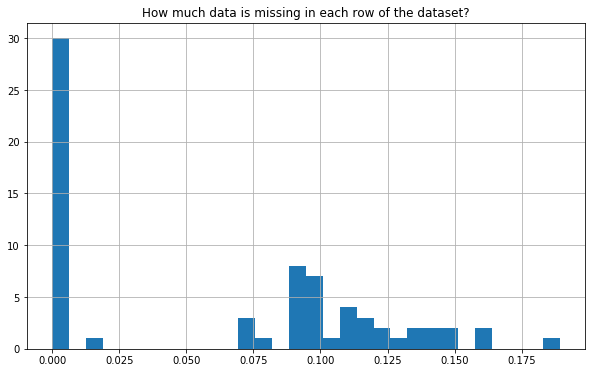

In [18]:
# How much data is missing in each row of the dataset?
title = 'How much data is missing in each row of the dataset?'
assessment2(azdias, (10,6), 30, '', '', title)

In [19]:
data = azdias.isnull().sum(axis=1)

def divide_data_subset1(azdias, val):
    return azdias.loc[data[data > val].index]

In [20]:
def divide_data_subset2(azdias, val):
    return azdias.loc[data[data < val].index]

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
first_subset = divide_data_subset1(azdias, 25)
display(first_subset.describe())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,93072.000000,93150.000000,93048.000000,93150.000000,93150.000000,93150.000000,93150.000000,93150.000000,93150.000000,93150.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.000000
mean,2.430838,1.527322,4.740693,3.208331,3.720472,3.128867,4.681406,4.723006,2.741245,3.729329,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,3.500000
std,0.868612,0.499256,1.645026,0.646835,0.853211,0.632145,0.876366,0.741135,0.639466,0.754298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.707107
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,3.000000
25%,2.000000,1.000000,4.000000,3.000000,4.000000,3.000000,5.000000,5.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,3.250000
50%,3.000000,2.000000,6.000000,3.000000,4.000000,3.000000,5.000000,5.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,3.500000
75%,3.000000,2.000000,6.000000,3.000000,4.000000,3.000000,5.000000,5.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,3.750000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,6.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,4.000000


In [22]:
second_subset = divide_data_subset2(azdias, 25)
display(second_subset.describe())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,795265.000000,798068.000000,793319.000000,798068.000000,798068.000000,798068.000000,798068.000000,798068.000000,798068.000000,798068.000000,...,733157.000000,785420.000000,769236.000000,767268.000000,774706.000000,774706.000000,774706.000000,793841.000000,702065.000000,793841.000000
mean,2.795413,1.521487,3.502899,3.058914,2.716053,3.432888,2.840960,2.658364,3.114096,3.797739,...,4.472086,619.701328,2.269353,2.829019,1.943913,3.612821,3.381087,3.166688,4.808314,3.071033
std,1.018407,0.499538,1.537613,1.377577,1.485092,1.376866,1.472784,1.399536,1.408108,2.084704,...,1.836357,340.034520,0.956637,0.882235,1.459654,0.973967,1.111598,0.999071,1.991626,1.360534
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,...,3.000000,384.000000,2.000000,2.000000,1.000000,3.000000,3.000000,3.000000,3.000000,2.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,4.000000,...,5.000000,549.000000,2.000000,3.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,6.000000,...,6.000000,778.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,7.000000,2300.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,8.000000,5.000000


In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Subset one.
first_row = first_subset.isnull().sum()/1000
first_row_features = first_row[first_row < 1.0].index

# Subset two.
second_row = second_subset.isnull().sum()/1000
second_row_features = second_row[second_row < 1.0].index

# The five features that appear in both subset.
compare = second_row_features.intersection(first_row_features)[:5]
pd.DataFrame(compare,columns=("Feature to compare",))

,Feature to compare
0,ANREDE_KZ
1,FINANZ_MINIMALIST
2,FINANZ_SPARER
3,FINANZ_VORSORGER
4,FINANZ_ANLEGER


In [24]:
def plot_features(subset, place, compare, figsize):
    sns.set(style="darkgrid")
    selected_subset = subset[compare]

    plt.figure(figsize=figsize)
    sns.countplot(x="variable", hue="value", data=pd.melt(selected_subset))
    plt.title("Subset {} thresthold with missing values below <1%".format(place))
    plt.show()

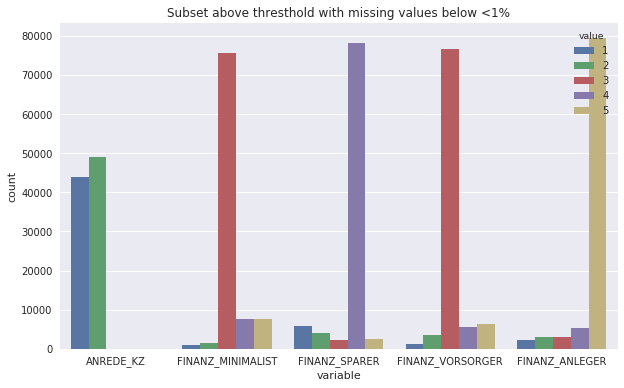

In [25]:
# Subset above thresthold with missing values below <1%.
plot_features(first_subset, 'above', compare, (10,6))

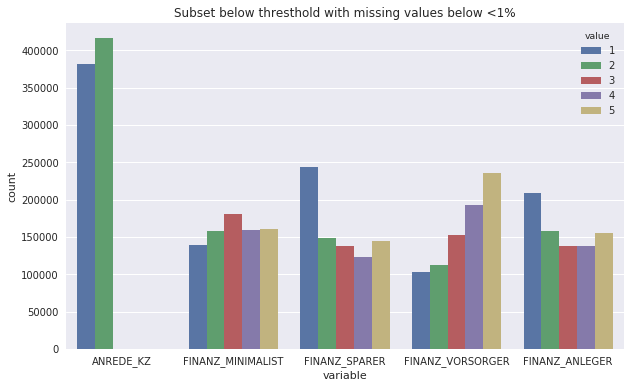

In [26]:
# Subset below thresthold with missing values below <1%.
plot_features(second_subset, 'below', compare, (10,6))

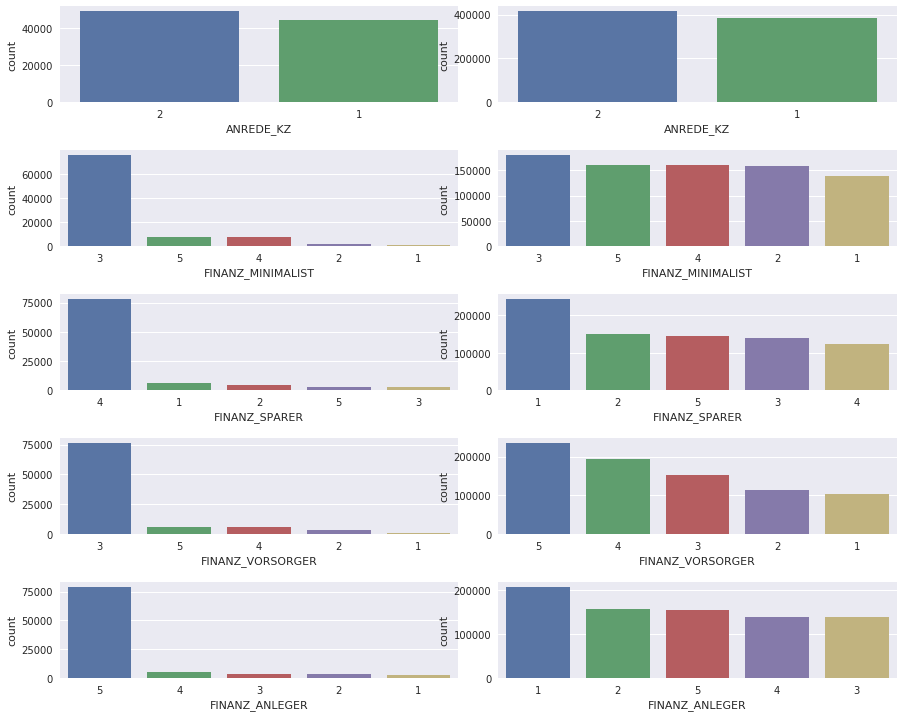

In [27]:
plt.figure(figsize=(15,15))
for i, j in enumerate(compare):  
    i1 = (i*2)+1
    i2 = (i*2)+2
       
    ax1 = plt.subplot(6, 2, i1)
    sns.countplot(x = j, data = first_subset, order = first_subset[j].value_counts().index)

    ax2 = plt.subplot(6, 2, i2)
    sns.countplot(x = j, data = second_subset, order = second_subset[j].value_counts().index)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.5)

plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

The dataset is divided into two subsets such as the first subset with missing values less than 25 and the other subset greater than 25. The graphs show us explicitly different. I suggest taking a look at the graphs above. And, 25 is my threshold.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
def features_count(feat_info, count):
    for i in feat_info['type']:
        count[i] += 1

In [29]:
# How many features are there of each data type?
count = Counter()
features_count(feat_info, count)
pd.DataFrame([count], index=("Features",))

,categorical,mixed,numeric,ordinal
Features,16,6,6,42


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
def assess_categorical(feat_info, binary, multi_level, second_subset):
    category = second_subset[feat_info[feat_info['type'] == 'categorical']['attribute']]
    for cat in category:
        if len(category[cat].value_counts()) == 2:
            binary.append(cat)
        else:
            multi_level.append(cat)
    return binary, multi_level, category 

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?


binary, multi_level, category = assess_categorical(feat_info, [], [], second_subset)
# Show binary variables table
display(pd.DataFrame(binary, columns=("Binary variables",)))

,Binary variables
0,ANREDE_KZ
1,GREEN_AVANTGARDE
2,VERS_TYP
3,OST_WEST_KZ


In [32]:
# Show multi-level variables table
display(pd.DataFrame(multi_level, columns=("Multi-level variables",)))

,Multi-level variables
0,CJT_GESAMTTYP
1,FINANZTYP
2,GFK_URLAUBERTYP
3,LP_FAMILIE_FEIN
4,LP_FAMILIE_GROB
5,LP_STATUS_FEIN
6,LP_STATUS_GROB
7,NATIONALITAET_KZ
8,ZABEOTYP
9,GEBAEUDETYP


In [33]:
def must_be_re_encoded(re_encode, binary, category):
    for v in binary:
        if category[v].dtype.kind in 'O':
            re_encode.append(v)
    return re_encode
        
re_encode = must_be_re_encoded([], binary, category)        
print("The categorical variables that must be re-encoded are {0}.".format(re_encode))

The categorical variables that must be re-encoded are ['OST_WEST_KZ'].


In [34]:
def re_encode_variables(re_encode, re_encoded, category):
    for i in re_encode:
        value = category[i].value_counts().index
        re_encoded = dict({i:{value[0]:0, value[1]:1}})
    return value, re_encoded


In [35]:
# Re-encode categorical variable(s) to be kept in the analysis.

value, re_encoded = re_encode_variables(re_encode, {}, category)
pd.DataFrame(re_encoded)

,OST_WEST_KZ
O,1
W,0


In [36]:
def replace_in_dataset(second_subset, re_encoded):
    second_subset_c = second_subset.copy()
    for i in re_encoded:
        for key,val in re_encoded[i].items():
            second_subset_c[i] = second_subset_c[i].replace(key, val)
    return second_subset_c
    

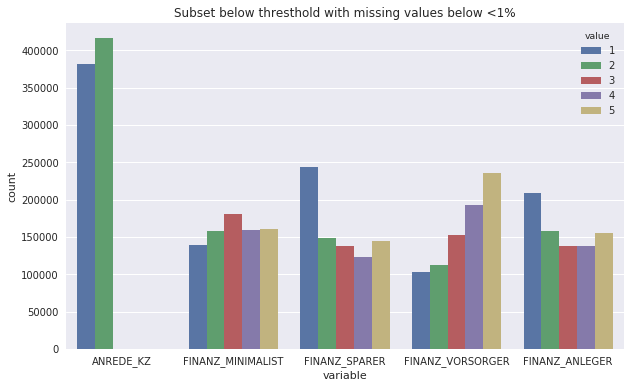

In [37]:
# Replace in the dataset
second_subset_c = replace_in_dataset(second_subset, re_encoded)

# Drop multi-level features
second_subset_c.drop(multi_level, axis=1, inplace=True)

# Print the graph
plot_features(second_subset_c, 'below', compare, (10,6))

#### Discussion 1.2.1: Re-Encode Categorical Features

The total dataset has 16 categorical features such as the multi-level is 12 and the binary is 4. Furthermore, we note that all the binary variables were kept, except **OST_WEST_KZ**, because they must be re-encoding, they have the binary type (O, W). So, I re-encoded numerically as (0,1). Moreover, I dropped all multi-level features from the dataset.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [38]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    azdias_copy = second_subset_c.copy()

    PRAEGENDE_DATA = azdias_copy[['PRAEGENDE_JUGENDJAHRE']]

    decade = {1: '40s', 2: '40s', 3: '50s', 4: '60s',
     5: '60s', 6: '60s', 7: '60s', 8: '70s',
     9: '70s', 10: '80s', 11: '80s', 12: '80s',
     13: '80s', 14: '90s', 15: '90s'}

    movement = {1: '[1, 4]', 2: '[2, 4]', 3: '[1, 4]', 4: '[2, 4]',
     5: '[1, 4]', 6: '[2, 2]', 7: '[2, 2]', 8: '[1, 4]',
     9: '[2, 2]', 10: '[1, 2]', 11: '[2, 2]', 12: '[1, E]',
     13: '[2, 2]', 14: '[1, 4]', 15: '[2, 4]'}

    PRAEGENDE_DATA["decade"] = PRAEGENDE_DATA["PRAEGENDE_JUGENDJAHRE"].map(decade)

    PRAEGENDE_DATA["movement"] = PRAEGENDE_DATA["PRAEGENDE_JUGENDJAHRE"].map(movement)

# Show the PRAEGENDE_DATA
PRAEGENDE_DATA.head()

,PRAEGENDE_JUGENDJAHRE,decade,movement
1,14.0,90s,"[1, 4]"
2,15.0,90s,"[2, 4]"
3,8.0,70s,"[1, 4]"
4,8.0,70s,"[1, 4]"
5,3.0,50s,"[1, 4]"


In [39]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    CAMEO_DATA = azdias_copy[['CAMEO_INTL_2015']]

    CAMEO_DATA['life_stage'] = CAMEO_DATA['CAMEO_INTL_2015'].str[1:2]

    CAMEO_DATA['Wealth'] = CAMEO_DATA['CAMEO_INTL_2015'].str[0:2]

# Show the CAMEO_DATA
CAMEO_DATA.head()

,CAMEO_INTL_2015,life_stage,Wealth
1,51,1,51
2,24,4,24
3,12,2,12
4,43,3,43
5,54,4,54


#### Discussion 1.2.2: Select and Re-Encode Features

Note that, we have 6 mixed features and all mixed features are dropped.  Also, the mixed features that must have a particular treatment before dropping are **PRAEGENDE_JUGENDJAHRE** and **CAMEO_INTL_2015**.

**PRAEGENDE_JUGENDJAHRE**:
- I created the decade parameter. The decade column holds an interval of 40s-90s.
- Also, I create the movement parameter. The movement holds binary of mainstream:0, avantgarde:1.

**CAMEO_INTL_2015** 
- I created **life_stage** field. The **life_stage** holds the ones digit.  
- Also, I created **Wealth** field.   The **wealth** holds the tens digit. 


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [40]:
def drop_mixed(mixed, category):
    for i in category:
        mixed.append(i)
    return mixed

In [41]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Drop mixed data type
category = azdias_copy[feat_info[feat_info['type'] == 'mixed']['attribute']]
mixed = drop_mixed([], category)

azdias_copy.drop(mixed, axis=1, inplace=True)

In [42]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798068 entries, 1 to 891220
Data columns (total 52 columns):
ALTERSKATEGORIE_GROB     795265 non-null float64
ANREDE_KZ                798068 non-null int64
FINANZ_MINIMALIST        798068 non-null int64
FINANZ_SPARER            798068 non-null int64
FINANZ_VORSORGER         798068 non-null int64
FINANZ_ANLEGER           798068 non-null int64
FINANZ_UNAUFFAELLIGER    798068 non-null int64
FINANZ_HAUSBAUER         798068 non-null int64
GREEN_AVANTGARDE         798068 non-null int64
HEALTH_TYP               761341 non-null float64
RETOURTYP_BK_S           793319 non-null float64
SEMIO_SOZ                798068 non-null int64
SEMIO_FAM                798068 non-null int64
SEMIO_REL                798068 non-null int64
SEMIO_MAT                798068 non-null int64
SEMIO_VERT               798068 non-null int64
SEMIO_LUST               798068 non-null int64
SEMIO_ERL                798068 non-null int64
SEMIO_KULT               798068 non-n

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [111]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    tab = ConvertMissingValueCodesToNaNs(df, [], feat_info)
    
    # remove selected columns and rows, ...
    remove_outlier(df, [], feat_info, missing)
    
    # values in each row.
    data = df.isnull().sum(axis=1)
    
    # Subset one
    first_subset = divide_data_subset1(df, 25)
    
    # Subset two
    second_subset = divide_data_subset2(df, 25)
    
    # select, re-encode, and engineer column values.
    binary, multi_level, category = assess_categorical(feat_info, [], [], second_subset)
    
    re_encode = must_be_re_encoded([], binary, category)    
    
    # Re-encoding as (0, 1).
    value, re_encoded = re_encode_variables(re_encode, {}, category)
    
    # Replace in the dataset
    second_subset = replace_in_dataset(second_subset, re_encoded)
    
    # Drop multi-level features
    second_subset.drop(multi_level, axis=1, inplace=True)
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    df_copy = second_subset.copy()

    PRAEGENDE_DATA = df_copy[['PRAEGENDE_JUGENDJAHRE']]

    decade = {1: '40s', 2: '40s', 3: '50s', 4: '60s',
         5: '60s', 6: '60s', 7: '60s', 8: '70s',
         9: '70s', 10: '80s', 11: '80s', 12: '80s',
         13: '80s', 14: '90s', 15: '90s'}

    movement = {1: '[1, 4]', 2: '[2, 4]', 3: '[1, 4]', 4: '[2, 4]',
         5: '[1, 4]', 6: '[2, 2]', 7: '[2, 2]', 8: '[1, 4]',
         9: '[2, 2]', 10: '[1, 2]', 11: '[2, 2]', 12: '[1, E]',
         13: '[2, 2]', 14: '[1, 4]', 15: '[2, 4]'}

    PRAEGENDE_DATA["decade"] = PRAEGENDE_DATA["PRAEGENDE_JUGENDJAHRE"].map(decade)

    PRAEGENDE_DATA["movement"] = PRAEGENDE_DATA["PRAEGENDE_JUGENDJAHRE"].map(movement)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    CAMEO_DATA = df_copy[['CAMEO_INTL_2015']]

    CAMEO_DATA['life_stage'] = CAMEO_DATA['CAMEO_INTL_2015'].str[1:2]

    CAMEO_DATA['Wealth'] = CAMEO_DATA['CAMEO_INTL_2015'].str[0:2]
    
    # Drop mixed data type
    category = df_copy[feat_info[feat_info['type'] == 'mixed']['attribute']]
    mixed = drop_mixed([], category)
    df_copy.drop(mixed, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df_copy, first_subset
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [44]:
# Apply feature scaling to the general population demographics data.

# Create an Imputer object from sklearn to the data
mean_imput = Imputer(missing_values='NaN', strategy='mean',
                     axis=0, verbose=0, copy=True).fit(azdias_copy)

# Apply the imputer to the df dataset
df_imput = mean_imput.transform(azdias_copy)

# Scalling
scale_fit = StandardScaler().fit(df_imput)

scale_transform  = scale_fit.transform(df_imput)

### Discussion 2.1: Apply Feature Scaling

I used the `Imputer` and `StandardScaler`. 

- `Mean Imputation` is quick and simple, but it would underestimate the variance and the distribution shape is distorted by replacing NaN with the mean value. The downside of imputing before feature scaling is that those features with more missing data will become ‘dampened’ in terms of measured variability. 

- The `StandardScaler` removes the mean and scales the data to unit variance. However, the outliers have an influence when computing the empirical mean and standard deviation which shrink the range of the feature values. Note in particular that because the outliers on each feature have different magnitudes, the spread of the transformed data on each feature is very different.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [45]:
# Apply PCA to the data.

sca_transform = PCA().fit(scale_transform)

pca_transform = sca_transform.transform(scale_transform)

In [46]:
def investigate_var(tab, figsize, title, x, y):
    for i,j in enumerate(var_ratio['Variance Explained'].values):
        tab.append(i+1)
    plt.figure(figsize=figsize)
    plt.bar(tab,var_ratio['Variance Explained'].values)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.xticks(tab)
    plt.show()

In [47]:
def map_weights(df, pca, n_component=1):
    
    dimension = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys())
    components.index = dimension
    n_component = components.iloc[n_component-1]
    
    # The results
    print("Most Positive Values\n\n", n_component.sort_values(ascending=False)[:10])
    print("\nMost Negative Values\n\n", n_component.sort_values(ascending=True)[:10])

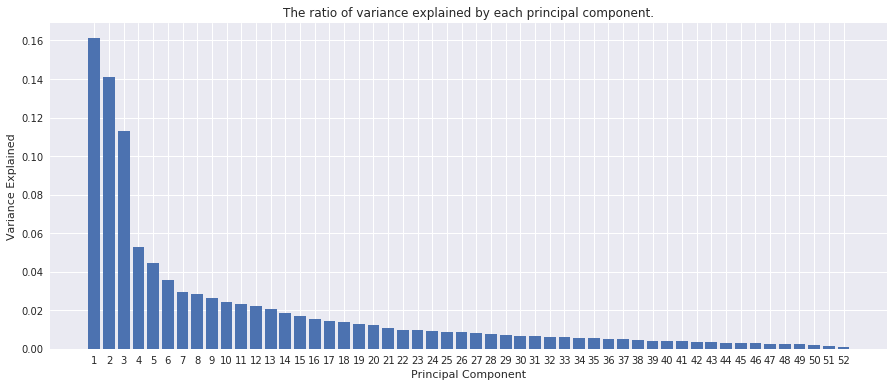

In [48]:
# Investigate the variance accounted for by each principal component.

pca = PCA().fit(scale_transform)
dimension = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA explained variance
ratio = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
var_ratio = pd.DataFrame(np.round(ratio, 4), columns = ['Variance Explained'])
var_ratio.index = dimension

# Create the plot
title = 'The ratio of variance explained by each principal component.'
x = 'Principal Component'
y = 'Variance Explained'
investigate_var([], (15,6), title, x, y)

In [49]:
# Re-apply PCA to the data while selecting for number of components to retain.

# The number of components
n_components = 23

# pca variable
pca = PCA(n_components=n_components).fit(scale_transform)

# Transform
principal_components = pca.transform(scale_transform)

# Explained variance calculation
(ratio[:n_components].sum()) / var_ratio.sum()

Variance Explained    0.858187
dtype: float64

### Discussion 2.2: Perform Dimensionality Reduction




I applied PCA to all the components and plotted the bar chart. This graph levels off rapidly after 23 components, i.e more components do not explain much more of the variance in our relevant variable. I took 23 principal components to use in the final PCA, because the explained variance > 80% (~0.85).



### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [50]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
map_weights(azdias_copy, pca, 1) 


Most Positive Values

 FINANZ_SPARER            0.2767
SEMIO_REL                0.2753
SEMIO_PFLICHT            0.2554
SEMIO_TRADV              0.2357
SEMIO_KULT               0.2193
FINANZ_UNAUFFAELLIGER    0.2136
SEMIO_FAM                0.1987
SEMIO_RAT                0.1951
FINANZ_ANLEGER           0.1886
SEMIO_MAT                0.1816
Name: Dimension 1, dtype: float64

Most Negative Values

 ALTERSKATEGORIE_GROB   -0.2799
FINANZ_VORSORGER       -0.2475
SEMIO_ERL              -0.2287
FINANZ_MINIMALIST      -0.2219
SEMIO_LUST             -0.1838
MOBI_REGIO             -0.1351
RETOURTYP_BK_S         -0.1219
PLZ8_ANTG1             -0.1218
KBA05_GBZ              -0.1159
KONSUMNAEHE            -0.0942
Name: Dimension 1, dtype: float64


In [51]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(azdias_copy, pca, 2)


Most Positive Values

 EWDICHTE               0.2343
FINANZ_HAUSBAUER       0.2295
HH_EINKOMMEN_SCORE     0.2048
ORTSGR_KLS9            0.2018
SEMIO_KAEM             0.1916
PLZ8_ANTG2             0.1876
ARBEIT                 0.1731
RELAT_AB               0.1670
ANREDE_KZ              0.1526
ANZ_HAUSHALTE_AKTIV    0.1515
Name: Dimension 2, dtype: float64

Most Negative Values

 MOBI_REGIO          -0.2445
PLZ8_ANTG1          -0.2318
KBA05_GBZ           -0.2253
INNENSTADT          -0.1958
KONSUMNAEHE         -0.1866
PLZ8_GBZ            -0.1799
SEMIO_VERT          -0.1594
FINANZ_MINIMALIST   -0.1591
SEMIO_KULT          -0.1575
BALLRAUM            -0.1540
Name: Dimension 2, dtype: float64


In [52]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(azdias_copy, pca, 3)


Most Positive Values

 SEMIO_VERT              0.3188
SEMIO_SOZ               0.2441
SEMIO_FAM               0.2187
SEMIO_KULT              0.1958
RETOURTYP_BK_S          0.1420
FINANZ_VORSORGER        0.1305
FINANZ_MINIMALIST       0.1279
W_KEIT_KIND_HH          0.1272
ALTERSKATEGORIE_GROB    0.1171
EWDICHTE                0.1037
Name: Dimension 3, dtype: float64

Most Negative Values

 ANREDE_KZ               -0.3444
SEMIO_KAEM              -0.3011
SEMIO_DOM               -0.2913
SEMIO_KRIT              -0.2455
SEMIO_RAT               -0.2408
FINANZ_ANLEGER          -0.2200
SEMIO_ERL               -0.1351
FINANZ_UNAUFFAELLIGER   -0.1344
FINANZ_SPARER           -0.1299
SEMIO_TRADV             -0.1183
Name: Dimension 3, dtype: float64


### Discussion 2.3: Interpret Principal Components

`Principal 1`

-The strongest positive feature weights: `PLZ8_ANTG3` and `PLZ8_ANTG4`, which shows high proposition of family homes, and relates to the size of inhabitants.

-The strongest negative feature weights: `PLZ8_ANTG1`, `MOBI_REGIO`, and `KBA05_ANTG1`, which indicates the prevalence of buildings with the smaller family capacity.


`Principal 2`

-The strongest positive feature weights: `ALTERSKATEGORIE_GROB` and `FINANZ_VORSORGER` which indicates a financial topology of very low prepared individuals. `FINANZ_HAUSBAUER` and `FINANZ_MINIMALIST` which also has to do with the financial topology with low home ownership and low financial interest.

-The strongest negative feature weights: `SEMIO_REL` and `SEMIO_PFLICHT`, which indicates how God fears the people.


`Principal 3`

-The strongest positive feature weights: `SEMIO_VERT`, `SEMIO_SOZ`, `SEMIO_KULT`, `SEMIO_FAM`, which has doing with the personality topology of the community and from these variables. 

-The strongest negative feature weights: `SEMIO_KAEM`, `SEMIO_DOM`, `SEMIO_KRIT`, `SEMIO_ERL`, `SEMIO_RAT`, which indicates mostly male attitudes. ANREDE_KZ, which indicates that the gender is mostly male than female.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. The largest value you should test should be at least 10 clusters, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [53]:
# Over a number of different cluster counts...
cluster_mean_distances = []
number_cluster = [2,5,7,10,12,15,17,20]
for i in number_cluster:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters = i, random_state = 20).fit(principal_components)
    
    # compute the average within-cluster distances.
    score = kmeans.score(principal_components)
    cluster_mean_distances.append(abs(score)) 
    

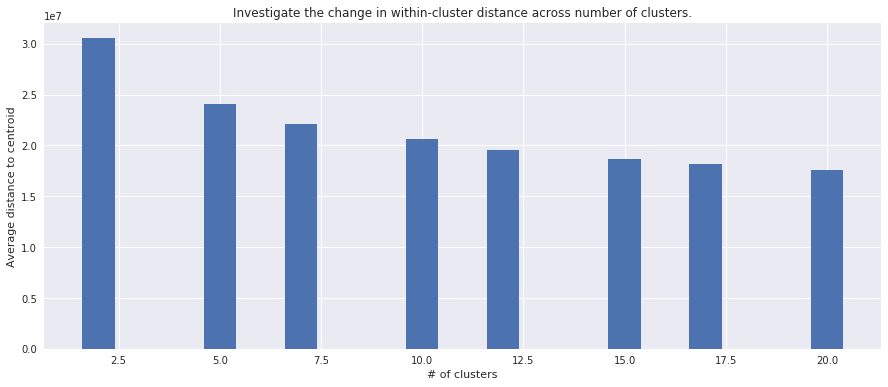

In [54]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(15,6))
plt.bar(number_cluster,cluster_mean_distances)
plt.title('Investigate the change in within-cluster distance across number of clusters.')
plt.xlabel('# of clusters')
plt.ylabel('Average distance to centroid')
plt.show()

In [55]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

def cluster_predict(principal_components, nbr_cluster):
    
    kmeans = KMeans(n_clusters = nbr_cluster, random_state = 20)
    

    kmeans = kmeans.fit(principal_components)
    

    centroid = kmeans.cluster_centers_

    prediction = kmeans.predict(principal_components)

    return (prediction, centroid)

nbr_cluster = 10
clu_predict, centroid = cluster_predict(principal_components, nbr_cluster)

### Discussion 3.1: Apply Clustering to General Population

I used 8 clusters to run KMeans, and computed the average score within cluster distances. Furthermore, I plot the bar chart to investigate the change in within-cluster distance across the number of clusters. We can observe that, after the 10th cluster, the distance did not decrease significantly. So, I chose 10 clusters for my final KMeans.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [144]:
# Load in the customer demographics data.
customers =  pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter = ";")

# Load in the feature summary file.
customers_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter = ";")


In [145]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()    
    # Apply preprocessing, feature transformation, and clustering from the general
    # demographics onto the customer data, obtaining cluster predictions for the
    # customer demographics data.

    # Apply clean_data
    clean_df, first_subset_c = clean_data(customers, customers_info)

    # Impute 
    nbr_customer = mean_imput.transform(clean_df) 

    # Cluster 
    customer_scale_features = scale_fit.transform(nbr_customer)
    
    # PCA
    pca_customer = pca.transform(customer_scale_features)

    predict_cl, centroid_cl = cluster_predict(pca_customer, nbr_cluster)

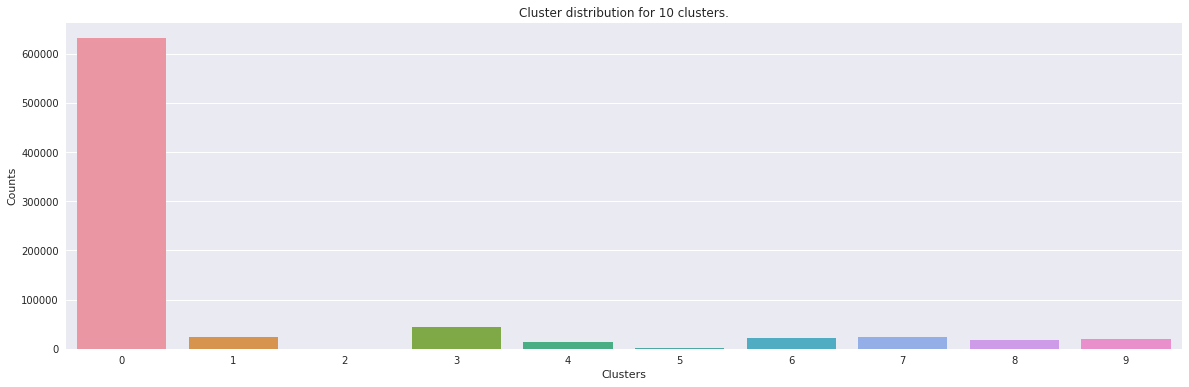

In [146]:
def plot_prediction(predict, normalize=False, add_rejected=False, rejected=None, sup=False):
    
    if add_rejected:
        negatives_ones = np.array([-1]*len(rejected))
        predict = np.hstack((predict, negatives_ones))
                          
    item, count = np.unique(predict,return_counts=True)
    
    if normalize:
        count = count/count.sum()
    sns.set(rc={'figure.figsize':(20,6)})
    plot = sns.barplot(item,count)
    
    
    y_label = "Counts"
    if normalize:
        y_label = "Proportion of data in cluster"
        
    if add_rejected and sup:
        plot.set(ylabel=y_label, xlabel='Clusters', title="Plot normalized graph for demographic data.")
    elif add_rejected:
        plot.set(ylabel=y_label, xlabel='Clusters', title="Plot normalized graph for customer data.")
    else:
        plot.set(ylabel=y_label, xlabel='Clusters', title="Cluster distribution for {} clusters.".format(nbr_cluster))

plot_prediction(predict_cl, normalize=False)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

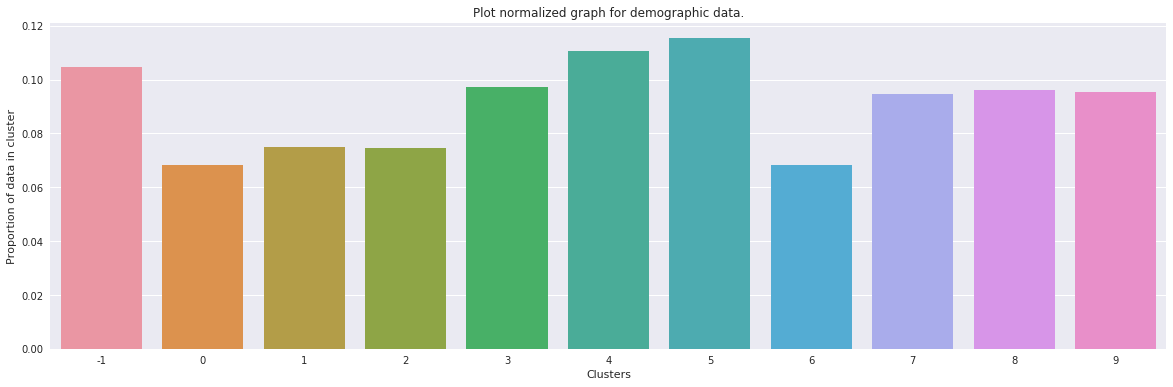

In [147]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Normalized graph for demographic data
plot_prediction(clu_predict, normalize=True, add_rejected=True,rejected = first_subset, sup=True)

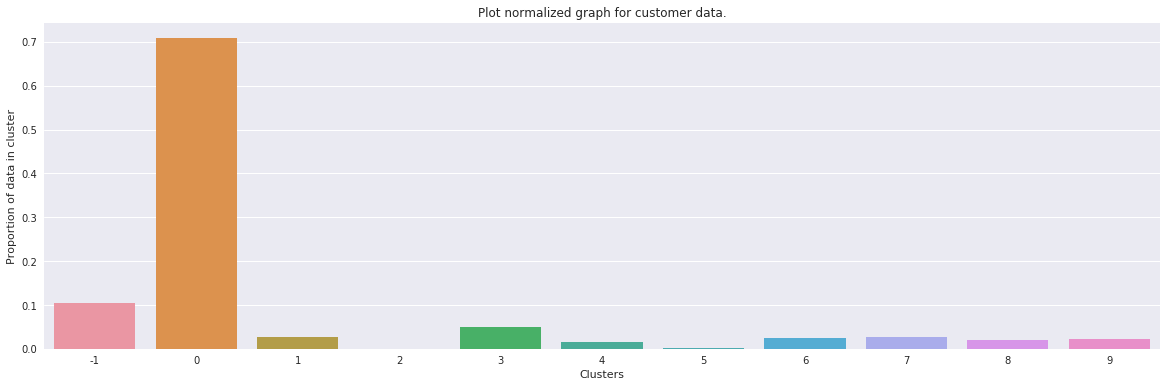

In [148]:
# Normalized graph for customer data
plot_prediction(predict_cl, normalize=True, add_rejected=True, rejected = first_subset_c, sup=False)

In [149]:
def plot_weights_distribution(prediction, df):
    x_values = [i+1 for i in range(52)]
    sns.set(rc={'figure.figsize':(20,6)})
    plot = sns.barplot(x_values, prediction)
  
    plot.set(ylabel="Weight", xlabel="Dimension", title="Features Weight")
    
    a_weights =  np.argsort(prediction)
    print("FEATURES WEIGHTS(INCREASING ORDER)\n")
    print(a_weights+1)
    
    print("\n\nFEATURES WITH HIGHEST WEIGHTS")
    display(df.columns[[a_weights[59:]]])
    
    print("\n\nFEATURES WITH LOWEST WEIGHTS")
    display(df.columns[[a_weights[:3]]])
    
    print("\nALL FEATURES IN CLUSTER")
    display(df.columns[[a_weights]])

In [150]:
# Inverse transform 
general_distribution = pca.inverse_transform(centroid)
customer_distribution = pca.inverse_transform(centroid_cl)

In [152]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Clusters [-1,0] are overrepresented in the customer dataset. We note that, -1 has a high difference between
# the two datasets. So, it needs a further analysis.

analyse_cluster = -1
general_distribution_over = general_distribution[analyse_cluster]
customer_distribution_over = customer_distribution[analyse_cluster]


FEATURES WEIGHTS(INCREASING ORDER)

[29  8  2  6 23 21  4 41 44 18 30 31 22 35  7 20 50 47 52 32 24 28  1 17 39
 38 37 34 51 25 14 48 33 15 40 45 11 12 10 26 46 49 13  5 19 36 43 42 16 27
  3  9]


FEATURES WITH HIGHEST WEIGHTS


Index([], dtype='object')



FEATURES WITH LOWEST WEIGHTS


Index(['HH_EINKOMMEN_SCORE', 'FINANZ_HAUSBAUER', 'ANREDE_KZ'], dtype='object')


ALL FEATURES IN CLUSTER


Index(['HH_EINKOMMEN_SCORE', 'FINANZ_HAUSBAUER', 'ANREDE_KZ', 'FINANZ_ANLEGER',
       'SEMIO_KAEM', 'SEMIO_KRIT', 'FINANZ_SPARER', 'KKK', 'REGIOTYP',
       'SEMIO_ERL', 'W_KEIT_KIND_HH', 'ANZ_HAUSHALTE_AKTIV', 'SEMIO_DOM',
       'OST_WEST_KZ', 'FINANZ_UNAUFFAELLIGER', 'SEMIO_RAT', 'ARBEIT',
       'PLZ8_ANTG2', 'RELAT_AB', 'ANZ_HH_TITEL', 'SEMIO_PFLICHT', 'ANZ_TITEL',
       'ALTERSKATEGORIE_GROB', 'SEMIO_LUST', 'INNENSTADT', 'EWDICHTE',
       'BALLRAUM', 'MIN_GEBAEUDEJAHR', 'ORTSGR_KLS9', 'SEMIO_TRADV',
       'SEMIO_REL', 'PLZ8_HHZ', 'KONSUMNAEHE', 'SEMIO_MAT',
       'GEBAEUDETYP_RASTER', 'KBA13_ANZAHL_PKW', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'HEALTH_TYP', 'VERS_TYP', 'PLZ8_ANTG1', 'PLZ8_GBZ', 'SEMIO_FAM',
       'FINANZ_VORSORGER', 'SEMIO_KULT', 'KBA05_GBZ', 'ONLINE_AFFINITAET',
       'MOBI_REGIO', 'SEMIO_VERT', 'ANZ_PERSONEN', 'FINANZ_MINIMALIST',
       'GREEN_AVANTGARDE'],
      dtype='object')

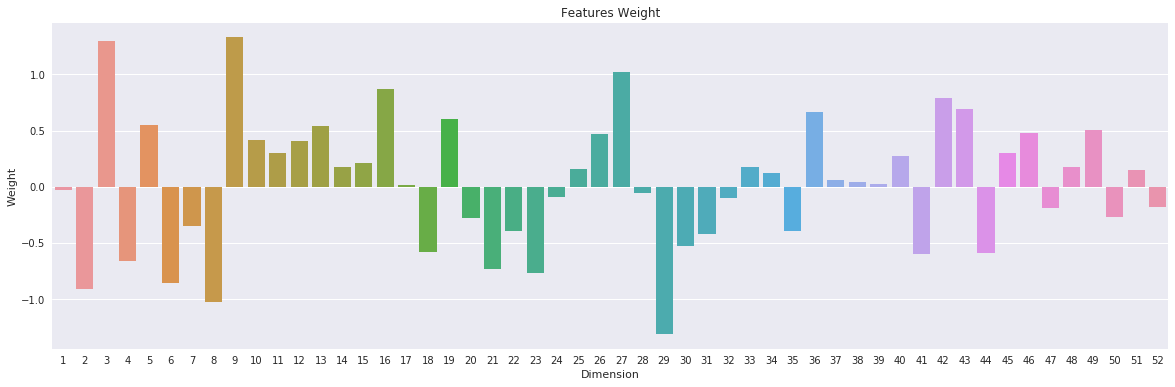

In [153]:
# Customer population weight.
plot_weights_distribution(customer_distribution_over, clean_df)


FEATURES WEIGHTS(INCREASING ORDER)

[29  8  2  6 23 21  4 41 44 18 30 31 22 35  7 20 50 47 52 32 24 28  1 17 39
 38 37 34 51 25 14 48 33 15 40 45 11 12 10 26 46 49 13  5 19 36 43 42 16 27
  3  9]


FEATURES WITH HIGHEST WEIGHTS


Index([], dtype='object')



FEATURES WITH LOWEST WEIGHTS


Index(['HH_EINKOMMEN_SCORE', 'FINANZ_HAUSBAUER', 'ANREDE_KZ'], dtype='object')


ALL FEATURES IN CLUSTER


Index(['HH_EINKOMMEN_SCORE', 'FINANZ_HAUSBAUER', 'ANREDE_KZ', 'FINANZ_ANLEGER',
       'SEMIO_KAEM', 'SEMIO_KRIT', 'FINANZ_SPARER', 'KKK', 'REGIOTYP',
       'SEMIO_ERL', 'W_KEIT_KIND_HH', 'ANZ_HAUSHALTE_AKTIV', 'SEMIO_DOM',
       'OST_WEST_KZ', 'FINANZ_UNAUFFAELLIGER', 'SEMIO_RAT', 'ARBEIT',
       'PLZ8_ANTG2', 'RELAT_AB', 'ANZ_HH_TITEL', 'SEMIO_PFLICHT', 'ANZ_TITEL',
       'ALTERSKATEGORIE_GROB', 'SEMIO_LUST', 'INNENSTADT', 'EWDICHTE',
       'BALLRAUM', 'MIN_GEBAEUDEJAHR', 'ORTSGR_KLS9', 'SEMIO_TRADV',
       'SEMIO_REL', 'PLZ8_HHZ', 'KONSUMNAEHE', 'SEMIO_MAT',
       'GEBAEUDETYP_RASTER', 'KBA13_ANZAHL_PKW', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'HEALTH_TYP', 'VERS_TYP', 'PLZ8_ANTG1', 'PLZ8_GBZ', 'SEMIO_FAM',
       'FINANZ_VORSORGER', 'SEMIO_KULT', 'KBA05_GBZ', 'ONLINE_AFFINITAET',
       'MOBI_REGIO', 'SEMIO_VERT', 'ANZ_PERSONEN', 'FINANZ_MINIMALIST',
       'GREEN_AVANTGARDE'],
      dtype='object')

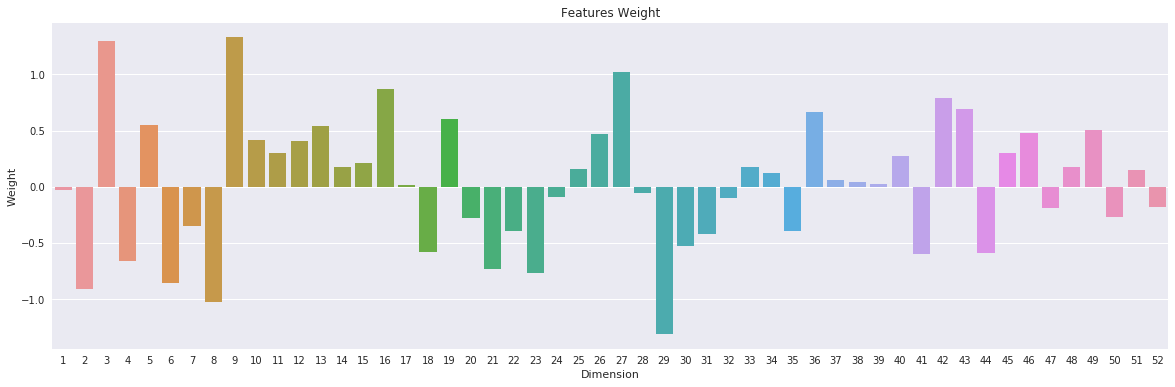

In [154]:
# General population weight
plot_weights_distribution(customer_distribution_over, azdias_copy)

In [155]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Clusters [1,2,3,4,5,6,7,8,9] are underrepresented in the customer dataset. We note that, 2 has a high difference between
# the two datasets. So, it needs a further analysis.
analyse_cluster = 2
general_distribution_under = general_distribution[analyse_cluster]
customer_distribution_under = customer_distribution[analyse_cluster]

FEATURES WEIGHTS(INCREASING ORDER)

[33 24  9  6 41  4 25 40 14 39 34 27 21  7 49 10 19 20 44 42  3 50 46 35 13
  2 15 45 36 22 52 23 26 12 16 29 43 47 18 17 37 51 48 30  1  5  8 11 38 28
 31 32]


FEATURES WITH HIGHEST WEIGHTS


Index([], dtype='object')



FEATURES WITH LOWEST WEIGHTS


Index(['KONSUMNAEHE', 'SEMIO_PFLICHT', 'GREEN_AVANTGARDE'], dtype='object')


ALL FEATURES IN CLUSTER


Index(['KONSUMNAEHE', 'SEMIO_PFLICHT', 'GREEN_AVANTGARDE', 'FINANZ_ANLEGER',
       'KKK', 'FINANZ_SPARER', 'SEMIO_TRADV', 'GEBAEUDETYP_RASTER',
       'SEMIO_REL', 'INNENSTADT', 'MIN_GEBAEUDEJAHR', 'ANZ_PERSONEN',
       'SEMIO_KRIT', 'FINANZ_UNAUFFAELLIGER', 'PLZ8_GBZ', 'HEALTH_TYP',
       'SEMIO_KULT', 'SEMIO_RAT', 'REGIOTYP', 'MOBI_REGIO',
       'FINANZ_MINIMALIST', 'ARBEIT', 'PLZ8_ANTG1', 'OST_WEST_KZ', 'SEMIO_FAM',
       'ANREDE_KZ', 'SEMIO_MAT', 'KBA13_ANZAHL_PKW', 'KBA05_GBZ', 'SEMIO_DOM',
       'RELAT_AB', 'SEMIO_KAEM', 'VERS_TYP', 'SEMIO_SOZ', 'SEMIO_VERT',
       'HH_EINKOMMEN_SCORE', 'ONLINE_AFFINITAET', 'PLZ8_ANTG2', 'SEMIO_ERL',
       'SEMIO_LUST', 'BALLRAUM', 'ORTSGR_KLS9', 'PLZ8_HHZ', 'W_KEIT_KIND_HH',
       'ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER', 'FINANZ_HAUSBAUER',
       'RETOURTYP_BK_S', 'EWDICHTE', 'ANZ_TITEL', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL'],
      dtype='object')

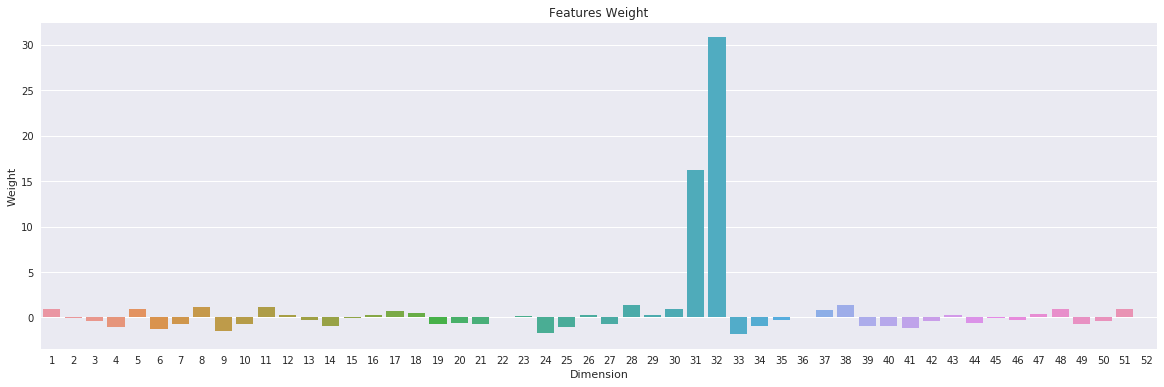

In [156]:
# Customer population weight   
plot_weights_distribution(customer_distribution_under, clean_df)

FEATURES WEIGHTS(INCREASING ORDER)

[33 24  9  6 41  4 25 40 14 39 34 27 21  7 49 10 19 20 44 42  3 50 46 35 13
  2 15 45 36 22 52 23 26 12 16 29 43 47 18 17 37 51 48 30  1  5  8 11 38 28
 31 32]


FEATURES WITH HIGHEST WEIGHTS


Index([], dtype='object')



FEATURES WITH LOWEST WEIGHTS


Index(['KONSUMNAEHE', 'SEMIO_PFLICHT', 'GREEN_AVANTGARDE'], dtype='object')


ALL FEATURES IN CLUSTER


Index(['KONSUMNAEHE', 'SEMIO_PFLICHT', 'GREEN_AVANTGARDE', 'FINANZ_ANLEGER',
       'KKK', 'FINANZ_SPARER', 'SEMIO_TRADV', 'GEBAEUDETYP_RASTER',
       'SEMIO_REL', 'INNENSTADT', 'MIN_GEBAEUDEJAHR', 'ANZ_PERSONEN',
       'SEMIO_KRIT', 'FINANZ_UNAUFFAELLIGER', 'PLZ8_GBZ', 'HEALTH_TYP',
       'SEMIO_KULT', 'SEMIO_RAT', 'REGIOTYP', 'MOBI_REGIO',
       'FINANZ_MINIMALIST', 'ARBEIT', 'PLZ8_ANTG1', 'OST_WEST_KZ', 'SEMIO_FAM',
       'ANREDE_KZ', 'SEMIO_MAT', 'KBA13_ANZAHL_PKW', 'KBA05_GBZ', 'SEMIO_DOM',
       'RELAT_AB', 'SEMIO_KAEM', 'VERS_TYP', 'SEMIO_SOZ', 'SEMIO_VERT',
       'HH_EINKOMMEN_SCORE', 'ONLINE_AFFINITAET', 'PLZ8_ANTG2', 'SEMIO_ERL',
       'SEMIO_LUST', 'BALLRAUM', 'ORTSGR_KLS9', 'PLZ8_HHZ', 'W_KEIT_KIND_HH',
       'ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER', 'FINANZ_HAUSBAUER',
       'RETOURTYP_BK_S', 'EWDICHTE', 'ANZ_TITEL', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL'],
      dtype='object')

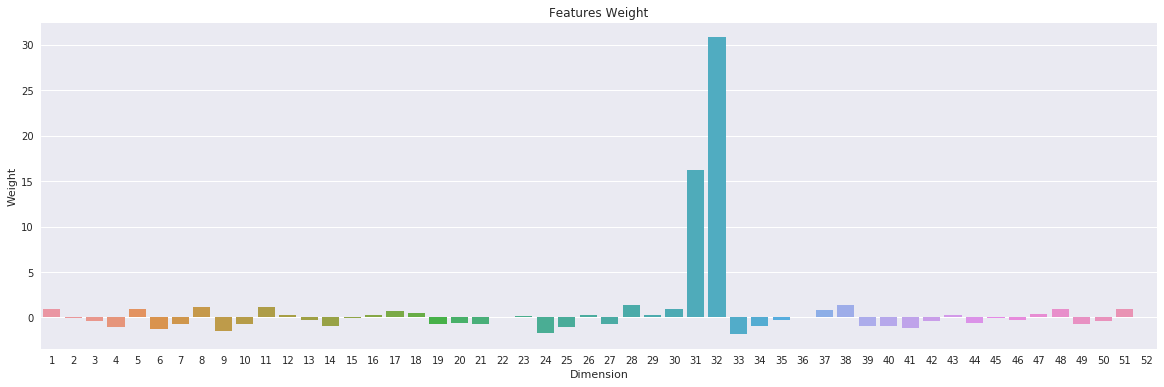

In [157]:
# General population weight
plot_weights_distribution(customer_distribution_under, azdias_copy)

### Discussion 3.3: Compare Customer Data to Demographics Data

- **Overrepresented**: 

From the barchart above, clusters [-1,0] are overrepresented in the customer dataset. I will analyse cluster -1 futher as it has a high difference between the two datasets.

Taking the inverse pca transform we can clearly see the dominating features in each clusters. we see a relativity in features. For example the features ALTERSKATEGORIE_GROB, FINANZ_MINIMALIST, ANZ_PERSONEN are more positive in customer than in genral population Which indicates that the customer population is made up more of older people with high financial interest. On the other hand, features ['HH_EINKOMMEN_SCORE', 'FINANZ_HAUSBAUER', 'ANREDE_KZ'] are More negative in general population and the customer population. This indicates that the customer population is have more people who save money and highly rational compare to the general population.

- **Underrepresented**: 

From the barchart above, clusters [1,2,3,4,5,6,7,8,9] are underrepresented in the customer dataset. I will analyse cluster 2 futher as it has a high difference between the two datasets.

From the inverse pca transform graph, we can see that more positive features in the general population is ANZ_HH_TITEL, ANZ_TITEL while the more positive features in the customer population is ['MOBI_REGIO', 'SEMIO_VERT', 'FINANZ_MINIMALIST']. This shows that the customer population is highly made up of people with very low mobility and low dreamful habitats. The customer population also has high financial interests. Also, we see that the features ['KONSUMNAEHE', 'SEMIO_PFLICHT', 'GREEN_AVANTGARDE'] are relatively more negative in general population and the customer population, telling us that the size of the community is less and are made up mostly of male with high combative attitutes.


In [69]:
# Difference between the two datasets

# How the null values are distributed throughout each dataset?
# Load in the customer demographics data.
customers_sub = pd.read_csv("Udacity_CUSTOMERS_Subset.csv",delimiter=";")

# Load in the general demographics data.
azdias_sub = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")



In [72]:
def plot_missing_val(df, title=None, x_label=None, y_label=None, kind = 'bar', x_size = 20, y_size = 6):
    '''
    Plot a bar chart of missing values
    '''
    bar = df.isnull().sum() / len(df)
    bar.plot(title=title, x =x_label, y=y_label, kind=kind, figsize=(x_size, y_size))

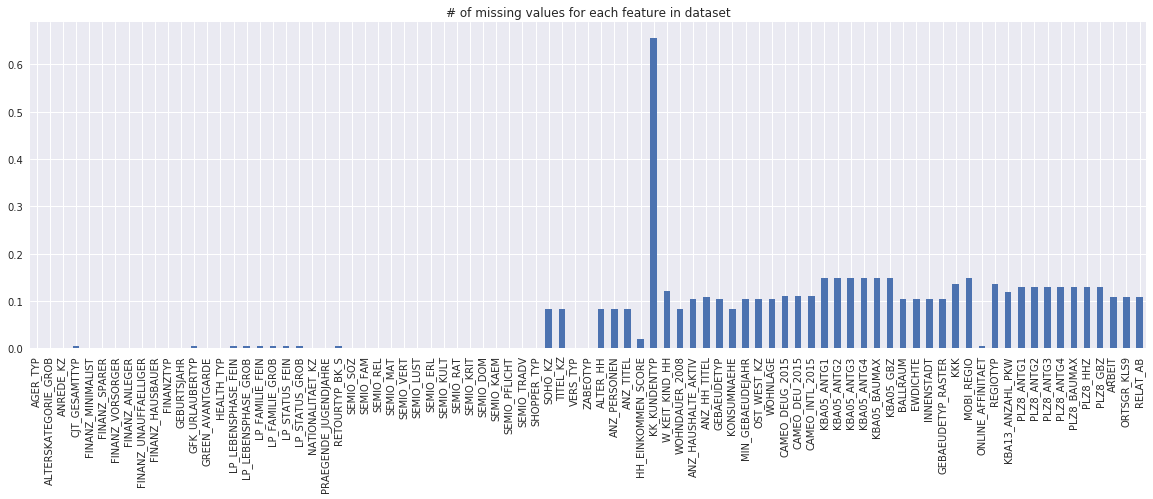

In [73]:
# Perform an assessment of how much missing data there is in each column of the dataset.
plot_missing_val(azdias_sub, '# of missing values for each feature in dataset',
                     'Features', '# Missing values')

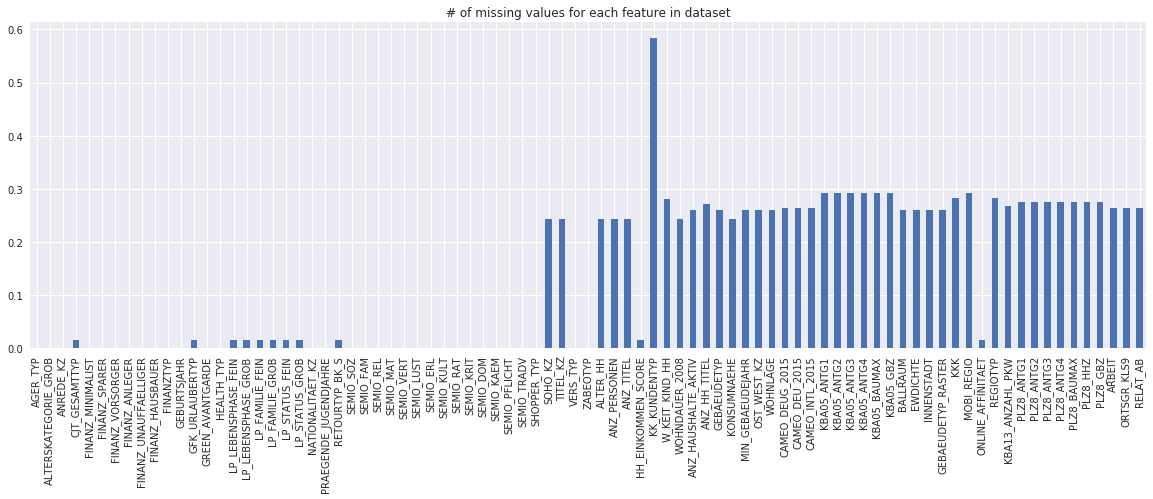

In [74]:
# Perform an assessment of how much missing data there is in each column of the dataset.
plot_missing_val(customers_sub, '# of missing values for each feature in dataset',
                     'Features', '# Missing values')

**Difference between the two datasets**

I have firstly, loading the customer demographics data and the general demographics data. Then, I've performed an assessment of how much missing data there is in each column of the dataset. To perform an assessment, I provided a bar chart for both datasets. Looking at the graphs above, we can conclude that, the customer dataset has more null values on the right of the graph such as SOHO_KZ, TITLE_KZ, ALTER_HH, ANZ_PERSONEN, ANZ_TITLE, WKEIT_KIND_HH, WOHNDAUER_2008, ANZ_HAUSHALTE_AKTIV, ANZ_HH_TITLE, GEBAEUDETYP, etc. You can observe the graphs to have more details on the comparison. The bar chart clearly shows the difference between the two datasets.



 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.